<a href="https://colab.research.google.com/github/MarcoAQS/seminario-/blob/main/ProyectoFinal_VertexCover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="Teal" face="Verdana,arial">
  <h1 align="center"><i>Proyecto Final</i></h1>
  </font>
  <font color="Black" face="Verdana,arial">
  <h5 align="center"><i>Profesora: 	Claudia Orquídea López Soto	 </i></h5>
  <h5 align="center"><i>Ayudante: Allison Odette Merino Trejo</i></h5>
  <h5 align="center"><i>Seminario de Investigación de Operaciones</i></h5>
  <h5 align="left"><i> Marco Antonio Quintero Santiago</i></h5>
  </font>



In [ ]:
import numpy as np
import random
import networkx as nx
import timeit
import matplotlib.pyplot as plt

# Definición del problema

Sea $G=(V,E)$ una gráfica no dirigida, donde $V$ es el conjunto de vértices y $E$ es el conjunto de aristas.

Un subconjunto $V^{\prime} \subseteq V$ es una cobertura de vértices si para cada arista $(i,j)\in E$, $i\in V^{\prime}$ o $j\in V^{\prime}$, es decir, todas las aristas tienen al menos un extremo en $V^{\prime}$.

Sea $n$ la cardinalidad del conjunto de vértices $V$, el problema de la cobertura de vértices consiste en encontrar una cobertura de vértices de tamaño mínimo. Para ello las soluciones seran expresadas como un vector binario de tamaño $n$ donde $x_{k} = 1$ si el vértice $k$ pertenece a la cobertura de vértices y $x_{k} = 0$ en caso contrario.

## Restricciones

Nuestro problema entonces solo tiene como restricción que el subconjunto encontrado en efectp sea una cobertura de vértices. Para ello implementamos la siguiente función que verifica que una solución (`lista`) es una cobertura de vértices.

In [ ]:
def cobertura(g, v):
    """
    Función que evalua si un subconjunto de vértices
    (expresado en forma binaria) es una cobertura de
    la gráfica.

    Input:
    - g: Una gráfica (usando networkx)
    - v: subconjunto de vértices (binario)

    Returns:
    - True (boolean) si el subconjunto de vértices es una cobertura
    - False (boolean) en otro caso
    """

    for arista in g.edges():
        if v[arista[0]] == 0 and v[arista[1]] == 0:
            return False # Si se encuentra una arista que no está cubierta, se regresa False
        pass # Si todas las aristas están cubiertas, se regresa True

    return True

## Función objetivo

Como buscamos minimizar el tamaño de la cobertura de vértices, nuestra función objetivo será el tamaño de la cobertura de vértices, el cual obtenemos simplemente sumando la cantidad de 1 en la solución. Para ciertas heuristicas se pueden aceptar soluciones no factibles (en nuestro caso subconjuntos de vértices que no son coberturas de vértices) y se puede penalizar estas soluciones con un valor muy grande. Implementamos la f.o. en la siguiente función.

In [ ]:
def penalizar(s):
    return len(s) + np.exp(sum(s))  # Permite penalizar una solución que no sea factible

def funcion_f(s,g):
    if not s:
        return 0
    elif cobertura(g,s):
        return sum(s)
    else: #Penalizamos una solución que no sea factible
        return penalizar(s)

## Vecindades

In [ ]:
def vecindadC(s, m = None):
    """"
    Función que nos da la vecindad de una solución s
    en la que se cambia el valor de un vértice en la posición i

    Input:
    - s: solución
    - k: número de vecinos a generar (Por defecto = None) (Este parametro no se usa
         en esta función, pero se deja para mantener la estructura de la siguiente vecindad)

    Returns:
    - vecinos: lista de soluciones vecinas a s
    """
    vecinos = []
    for i in range(len(s)):
        vecino = s.copy()
        vecino[i] = 1 - vecino[i]
        vecinos.append(vecino)

    return vecinos


def vecindadRK(s,m = 1):
    """
    Funcion que nos da la vecindad de una solucion s en la que se cambia el valor de un
    numero especifico m de vertices aleatorios a los que se les cambia el valor generando
    asi m vecinos.

    Input:
    - s: solucion
    - m: numero de vecinos a generar (Por defecto = 1)

    Returns:
    - vecinos: lista de soluciones vecinas a s
    """
    vecinos = []
    for _ in range(m):
        vecino = s.copy()
        j = random.randint(0,len(s)-1)
        vecino[j] = 1 - vecino[j]
        vecinos.append(vecino)

    return vecinos

# Generación de instancias

Usamos la siguiente función para crear una grafica no dirigida con $n$ vértices

In [ ]:
def genera_grafica_aleatoria(n:int, p:float = 1):
    """
    Funcion para generar n vertices con una probabilidad p
    de agregar la arista que una dos vertices

    Input:
    - n (int): Numero de nodos de la grafica.
    - p (float): Proba de agregar una arista (Por defecto 1 para generar
                 una grafica completa).

    Returns:
    - g (nx.Graph): La grafica generada.
    """
    g = nx.Graph() #Creamos el objeto grafica
    g.add_nodes_from(range(n))
    for i in range(n): #Iteramos sobre los nodos
        for j in range(i+1, n): #Iteramos sobre los nodos restantes (evitando rizos)
            if random.random() < p:
                g.add_edge(i, j) #Agregamos la arista con probabilidad p
    return g

# Construcción de soluciones iniciales

## De forma aleatoria

In [ ]:
def genera_solucion_aleatoria(g,p = 0.75):
    """
    Se genera una solucion de tamaño n y se verifica que
    sea una solucion factible, en caso de que no sea factible
    se itera por cada una de las entradas de la solucion para
    cambiar la entrada i por un 1 con probabilidad p.

    Input:
    - g (nx.Graph): La grafica con la que se esta trabajando
    - p (float) : La probabilidad con la que se cambia una
                  entrada de la solucion (por defecto 0.75).


    Returns:
    sol: Una lista con una solucion factible generada al azar.
    """
    n = len(g.nodes())
    sol = [random.randint(0, 1) for _ in range(n)]
    k = 0

    #evaluamos si la solución es factible
    while not cobertura(g,sol):
        if k == n: # Reiniciamos la solución por si no se encuentra una factible
            k = 0

        r = random.random()

        if r < p:
            sol[k] = 1
        else:
            sol[k] = 0
        k+=1

    return sol

## Greedy

In [ ]:
def greedy(g,fun=funcion_f):
    """
    Función que implementa el algoritmo greedy para encontrar
    una cobertura de la gráfica g.

    Input:
    - g: Una gráfica
    - fun: Función objetivo (Por defecto es la funcion_f)

    Returns:
    - s: Una solución factible (cobertura de la gráfica)
    """
    n = len(g.nodes())
    s = [0] * n
    f = fun(s,g)
    F = [0] * n

    min = float("inf")

    while not cobertura(g, F): # Iteramos hasta encontrar una solución factible
        for i in range(n):
            if F[i] == 0:
                s = F.copy()
                s[i] = 1
                if fun(s, g) < min: #Si la solución es mejor que la anterior
                    min = f         # actualizamos el valor de min
        F = s
    return s

# Búsqueda local

In [ ]:
def busqueda_local(g,s0,  n=100,  m=1, N = vecindadC, f=funcion_f, timer = True):
    """
    Funcion que realiza la busqueda local a partir de una solucion inicial.

    Input:
    - s0: La solucion inicial.
    - g: La grafica de la instancia.
    - n: Numero de iteraciones (por defecto: 10).
    - m: Parametro opcional (necesario para la vecindadRK) (por defecto: 1).
    - N: La vecindad a usar (por defecto: vecindadC).
    - f: La funcion objetivo (por defecto: funcion_f).
    - timer: Si se desea regresar el tiempo que tarda en ejecutar la heuristica.
             (por defecto: True)


    Returns:
    x: La solucion "optima" encontrada.
    z: El valor de la solucion en la f.o.

    """
    start = timeit.default_timer()

    x = s0
    z = f(x, g)

    k = 0

    while k < n:
        vecinos = N(x, m)
        y = min(vecinos, key=lambda x: f(x, g))
        w = f(y, g)

        if w < z and cobertura(g, y):
            x = y
            z = w
            k += 1
        else:
            k += 1

    end = timeit.default_timer()
    t_time = round(end - start,6)

    if timer:
        return x,z, t_time
    return x, z

# GRASP

In [ ]:
def grado(g):
  """
    Funcion que calcula el grado (numero de vecinos) de cada vertice de una grafica.

    Input:
    g (graph): La grafica a trabajar.

    Returns:
    list: Una lista de tuplas ordenada de manera descendente de acuerdo al grado
          de cada vertice.
  """
  nodes = []
  for v in g.nodes():
      k = 0
      for edge in g.edges():
          if v == edge[0] or v == edge[1]:
              k += 1
      nodes.append((v,k))
      k = 0
  return sorted(nodes, key=lambda x: x[1], reverse=True)

## Construcción C

In [ ]:
def grasp_c(g,k,m = 1,c = grado, N = vecindadC, timer = True):
    """
    Funcion que implmenta la construccion C para aplicarle la busqueda local
    tomando los mejores k elementos de la RCL.

    Input:
    - g: Una grafica
    - k: Numero de elementos a tomar de la RCL
    - c: Funcion de costo (Por defecto es la funcion grado)

    Returns:
    - x: Una solucion factible (cobertura de la grafica)
    """
    start = timeit.default_timer()

    n = len(g.nodes())
    x = [0] * n
    C = c(g) #Nuestra funcion de costo gloton es el grado de los vertices
    s = 0

    while C:
        RCL = C[:k]
        v = random.choice(RCL)
        x[v[0]] = 1
        C.remove(v)
        s += 1

    end = timeit.default_timer()
    t_time = round(end - start,6)

    if timer:
        fs = busqueda_local(g,x, N = N, m=m)
        return fs[0], fs[1],t_time + fs[-1]
    return busqueda_local(g,x, N = N, m=m, timer = False)



## Construcción V

In [ ]:
def grasp_v(g,alpha,m=1,c = grado, N = vecindadC, timer = True):

    start = timeit.default_timer()

    n = len(g.nodes())
    x = [0] * n
    C = c(g)

    while C:
        d_sub = min(C, key=lambda x: x[1])
        d_supra = max(C, key=lambda x: x[1])

        RCL = [x for x in C if x[1] <= d_sub[1] + alpha * (d_supra[1] - d_sub[1])]

        v = random.choice(RCL)
        x[v[0]] = 1
        C.remove(v)

    end = timeit.default_timer()
    t_time = round(end - start,6)

    if timer:
        fs = busqueda_local(g,x, N = N, m=m)
        return fs[0], fs[1],t_time + fs[-1]
    return busqueda_local(g,x, N = N, m=m, timer = False)

## Construccion PG

In [ ]:
def perturbar(g,c=grado, Rsort = False):
    """
    Funcion para calcular el costo miope perturbado de una vecindad de soluciones
    Input:
    - g: grafica
    - c: funcion de costo (Por defecto es la función grado)
    - Rsort: Booleano para ordenar la perturbacion (Por defecto es False)

    Returns:
    - perturbacion: lista de tuplas con el vertice y el costo perturbado
    """
    costos = c(g)
    perturbacion =[]

    d_min = min(costos, key=lambda x: x[1])

    for i in range(len(costos)):
        p = random.random()

        if p < 1/3:
            perturbacion.append((costos[i][0],d_min[1]))
        elif p < 2/3:
            perturbacion.append((costos[i][0],0))
        else:
            perturbacion.append((costos[i][0],-d_min[1]))

    if Rsort:
        return sorted(perturbacion, key = lambda x: x[1], reverse = True)
    return perturbacion

In [ ]:
def grasp_pg(g, m=1,per = perturbar, N = vecindadC, timer = True):

    start = timeit.default_timer()

    n = len(g.nodes())
    x = [0] * n
    C = per(g)

    while C:
        e_sub = min(C, key=lambda x: x[1])
        x[e_sub[0]] = 1
        C.remove(e_sub)

    end = timeit.default_timer()
    t_time = round(end - start,6)

    if timer:
        fs = busqueda_local(g,x, N = N, m=m)
        return fs[0], fs[1],t_time + fs[-1]
    return busqueda_local(g,x, N = N, m=m, timer = False)

# Recocido Simulado

In [ ]:
def rsim(g,s0,T0= 1000, Tf = 0.01, alpha = 0.85, beta = 0.005, m = 1, prinT = True, N = vecindadC, fun = funcion_f, graph = False, timer = True):
    start = timeit.default_timer()

    T = T0
    k = 0
    T_data = []

    while T > Tf:
        vecinos = N(s0,m)
        s = random.choice(vecinos)

        delta = fun(s,g) - fun(s0,g)

        if delta < 0:
            s0 = s
            k += 1
        else:
            r = random.random()
            if r < np.exp(-delta/T0):
                s0 = s
                k += 1

        if prinT:
            print(f"Temp: {T}, Solucion: {s0}, Funcion objetivo: {fun(s0,g)}")


        if k % 3 == 0 and k != 0:
            T = alpha*T

        if not cobertura(g,s0):
            T = T * (1+beta)

        T_data.append(T)

    end = timeit.default_timer()
    t_time = round(end - start,6)

    if graph:
        import matplotlib.pyplot as plt

        plt.plot(T_data)
        plt.title("Temperatura vs Iteracion")
        plt.xlabel("Iteracion")
        plt.ylabel("Temperatura")
        plt.show()

    if timer:
        return s0, fun(s0,g), t_time
    return s0, fun(s0,g)

# Busqueda Tabú

In [ ]:
def tabu(g, s0, max_res = 3,n=100, m=1, N=vecindadC, fun=funcion_f, timer = True):
    start = timeit.default_timer()

    s = s0
    f_sup = fun(s, g)
    s_sup = s
    T = []  # Lista tabu de soluciones prohibidas junto con su tiempo restante de prohibicion
    k = 0

    while k < n:
        vecinos = [x for x in N(s, m) if x not in T]  # Filtrar vecinos que están en la lista tabu
        X = min(vecinos, key=lambda x: fun(x, g))

        if fun(X, g) < f_sup:
            s = X
            f_sup = fun(s, g)
            s_sup = s

            # Agregar la nueva solución a la lista tabu con sus iteraciones de prohibicion
            T.append([s_sup, max_res])
            # Reducir en uno el tiempo de prohibicion de cada solución en la lista tabu
            for sol in T:
                sol[1] -= 1
                if sol[1] == 0:
                    T.remove(sol)

        k += 1

    end = timeit.default_timer()
    t_time = round(end - start,6)

    if timer:
        return s_sup, f_sup, t_time
    return s_sup, f_sup


# Géneticos

In [ ]:
def genera_pob(s0,n = 10, m = 100, N = vecindadRK):
    pob = [s0]
    k = len(s0)
    for _ in range(n // 2):
        pob.append(random.choice(N(s0,m)))

    for _ in range((n // 2)-1):
        pob.append([random.randint(0, 1) for _ in range(k)])
    return pob

In [ ]:
def aptitud(pob,g, fun = funcion_f):
    return [(x,fun(x,g)) for x in pob]

In [ ]:
def cruza(p1,p2, corte):
    h1 = p1[:corte] + p2[corte:]
    h2 = p2[:corte] + p1[corte:]

    return h1,h2

In [ ]:
def torneo(pob):
    p1 = []
    p2 = []

    candidato1_1 = random.choice(pob)
    candidato1_2 = random.choice(pob)

    if candidato1_1[1] < candidato1_2[1]:
        p1 = candidato1_1[0]
    else:
        p1 = candidato1_2[0]

    candidato2_1 = random.choice(pob)
    candidato2_2 = random.choice(pob)

    if candidato2_1[1] < candidato2_2[1]:
        p2 = candidato2_1[0]
    else:
        p2 = candidato2_2[0]

    return p1,p2

In [ ]:
def geneticos2(g,k,s0,pcruza=0.75,i = 10, j = 100, N = vecindadRK, timer = True):
    start_t = timeit.default_timer()

    pob = genera_pob(s0,i,j,N)
    apt = aptitud(pob,g)

    new_pob = pob

    padres = None
    hijos = None

    n = len(pob)
    m = len(g.nodes())

    for _ in range(k):
        pob = new_pob
        new_pob = []
        apt = aptitud(pob,g)

        for _ in range(n//2):
            padres = torneo(apt)

            v = random.random()
            if v < pcruza:
                hijos = cruza(padres[0],padres[1],int(m/2))
            else:
                hijos = padres

            new_pob.append(hijos[0])
            new_pob.append(hijos[1])

            hijos = None
            padres = None

        if m >= 50:
            u = random.randint(0,n-1)
            new_pob[u] = [random.randint(0, 1) for _ in range(n)]


    fin = aptitud(new_pob,g)

    end_t = timeit.default_timer()
    t_time = round(end_t - start_t,6)

    if timer:
        fs = min(fin, key = lambda x: x[1])
        return fs[0], fs[1], t_time
    return min(fin, key = lambda x: x[1])


In [ ]:
def geneticos(g,k,s0,pcruza=0.75,i = 10, j = 100, N = vecindadRK, timer = True):
    start_t = timeit.default_timer()

    pob = genera_pob(s0,i,j,N)
    apt = aptitud(pob,g)

    n = len(pob)
    m = len(g.nodes())

    for _ in range(k):
        new_pob = []
        #new_apt = apt

        for _ in range(n//2):
            padres = torneo(apt)

            v = random.random()
            if v < pcruza:
                hijos = cruza(padres[0],padres[1],int(m/2))
            else:
                hijos = padres

            new_pob.append(hijos[0])
            new_pob.append(hijos[1])

        if n >= 50: # Si la poblacion es mayor o igual a 50 mutamos a un individuo
            u = random.randint(0,n-1)
            new_pob[u] = [random.randint(0, 1) for _ in range(m)]

        apt = aptitud(new_pob,g)
        pob = new_pob

    fin = aptitud(pob,g)

    end_t = timeit.default_timer()
    t_time = round(end_t - start_t,6)

    if timer:
        fs = min(fin, key = lambda x: x[1])
        return fs[0], fs[1], t_time
    return min(fin, key = lambda x: x[1])


# Pruebas

In [ ]:
def graph_inducida(s):
    nodes = [i for i in range(len(s)) if s[i] == 1]
    return nodes

## Tamaño "pequeño"

In [ ]:
# Graficas de tamaño "pequeño"
n1_g, n2_g, n3_g = 4, 6, 10

random.seed(0)
g1 = genera_grafica_aleatoria(n1_g, 0.8) # Como tenemos pocos vertices damos una probabilidad alta
g2 = genera_grafica_aleatoria(n2_g, 0.65) # de agregar aristas para que no quede una grafica muy
g3 = genera_grafica_aleatoria(n3_g, 0.6) # dispersa o disconexa

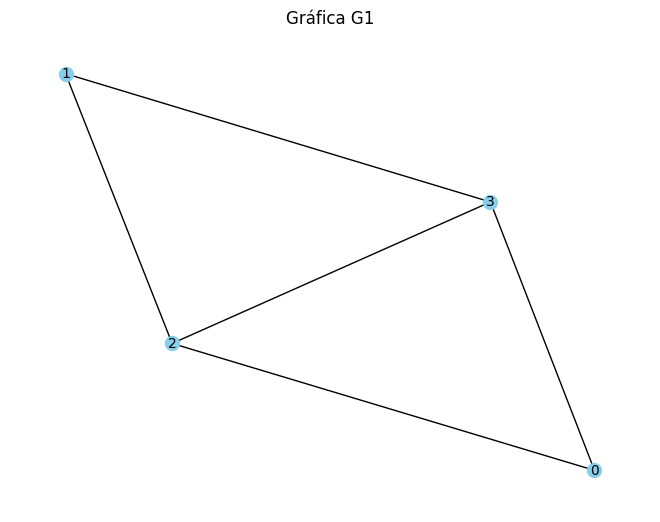

In [ ]:
nx.draw(g1, with_labels=True, node_color='skyblue', node_size=100, font_size=10)
plt.title('Gráfica G1')
plt.show()

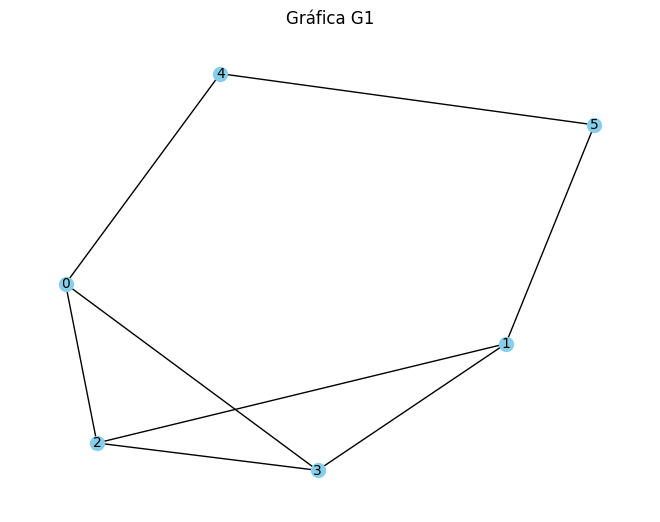

In [ ]:
nx.draw(g2, with_labels=True, node_color='skyblue', node_size=100, font_size=10)
plt.title('Gráfica G1')
plt.show()

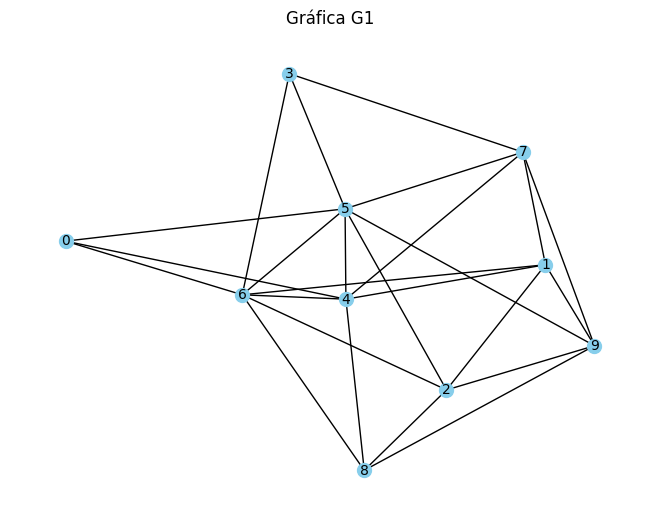

In [ ]:
nx.draw(g3, with_labels=True, node_color='skyblue', node_size=100, font_size=10)
plt.title('Gráfica G1')
plt.show()

### Construcción de soluciones iniciales

In [ ]:
random.seed(1)
g1_s0_greedy = greedy(g1)
g1_s0_r = genera_solucion_aleatoria(g1)

g1_s0_greedy, g1_s0_r

([0, 0, 1, 1], [1, 1, 1, 0])

In [ ]:
random.seed(2)
g2_s0_greedy = greedy(g2)
g2_s0_r = genera_solucion_aleatoria(g2)

g2_s0_greedy, g2_s0_r

([0, 0, 1, 1, 1, 1], [1, 1, 0, 1, 0, 1])

In [ ]:
random.seed(0)
g3_s0_greedy = greedy(g3)
g3_s0_r = genera_solucion_aleatoria(g3)

g3_s0_greedy, g3_s0_r

([0, 0, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 0, 0, 1])

### Instancia 1

4 vértices

#### Solución Greedy

##### VecindadC (Default)

In [ ]:
random.seed(3)
g1_s_greedy_bl = busqueda_local(g1, g1_s0_greedy)
g1_s_greedy_grasp_c = grasp_c(g1, 2)
g1_s_greedy_grasp_v = grasp_v(g1, 0.5)
g1_s_greedy_grasp_pg = grasp_pg(g1)
g1_s_greedy_rsim = rsim(g1, g1_s0_greedy, alpha = 0.90, prinT=False, graph=False)
g1_s_greedy_tabu = tabu(g1, g1_s0_greedy)
g1_s_greedy_gen = geneticos(g1, 10, g1_s0_greedy)

g1_s_greedy_bl, g1_s_greedy_grasp_c, g1_s_greedy_grasp_v, g1_s_greedy_grasp_pg, g1_s_greedy_rsim, g1_s_greedy_tabu, g1_s_greedy_gen


(([0, 0, 1, 1], 2, 0.00198),
 ([0, 0, 1, 1], 2, 0.003164),
 ([0, 0, 1, 1], 2, 0.002202),
 ([0, 0, 1, 1], 2, 0.003209),
 ([0, 0, 1, 1], 2, 0.004602),
 ([0, 0, 1, 1], 2, 0.001865),
 ([0, 0, 1, 1], 2, 0.001224))

##### VecindadRK, 4 vecinos

In [ ]:
random.seed(0)
g1_s_greedy_bl_rk = busqueda_local(g1, g1_s0_greedy, N=vecindadRK, m=4)
g1_s_greedy_grasp_c_rk = grasp_c(g1, 2, N=vecindadRK, m=4)
g1_s_greedy_grasp_v_rk = grasp_v(g1, 0.5, N=vecindadRK, m=4)
g1_s_greedy_grasp_pg_rk = grasp_pg(g1, N=vecindadRK, m=4)
g1_s_greedy_rsim_rk = rsim(g1, g1_s0_greedy, N=vecindadRK, m=4, prinT=False, graph=False)
g1_s_greedy_tabu_rk = tabu(g1, g1_s0_greedy, N=vecindadRK, m=4)

g1_s_greedy_bl_rk, g1_s_greedy_grasp_c_rk, g1_s_greedy_grasp_v_rk, g1_s_greedy_grasp_pg_rk, g1_s_greedy_rsim_rk, g1_s_greedy_tabu_rk


(([0, 0, 1, 1], 2, 0.009774),
 ([0, 0, 1, 1], 2, 0.004104999999999999),
 ([1, 1, 1, 0], 3, 0.004731),
 ([0, 0, 1, 1], 2, 0.004447),
 ([0, 1, 1, 1], 3, 0.00386),
 ([0, 0, 1, 1], 2, 0.002387))

#### Solucion Aleatoria

##### VecindadC

In [ ]:
random.seed(1)
g1_s_rand_bl = busqueda_local(g1, g1_s0_r)
g1_s_rand_rsim = rsim(g1, g1_s0_r, alpha = 0.95, prinT=False, graph=False)
g1_s_rand_tabu = tabu(g1, g1_s0_r)
g1_s_rand_gen = geneticos(g1, 10, g1_s0_r)

g1_s_rand_bl, g1_s_rand_rsim, g1_s_rand_tabu, g1_s_rand_gen

(([1, 1, 1, 0], 3, 0.005615),
 ([1, 1, 1, 1], 4, 0.02254),
 ([1, 1, 1, 0], 3, 0.002179),
 ([1, 1, 1, 0], 3, 0.001231))

##### VecindadRK, 4 vecinos

In [ ]:
random.seed(0)
g1_s_rand_bl_rk = busqueda_local(g1, g1_s0_r, N=vecindadRK, m=4)
g1_s_rand_rsim_rk = rsim(g1, g1_s0_r, N=vecindadRK, m=4, prinT=False, graph=False)
g1_s_rand_tabu_rk = tabu(g1, g1_s0_r, N=vecindadRK, m=4)

g1_s_rand_bl_rk, g1_s_rand_rsim_rk, g1_s_rand_tabu_rk

(([1, 1, 1, 0], 3, 0.002612),
 ([0, 1, 1, 1], 3, 0.005611),
 ([1, 1, 1, 0], 3, 0.0047))

In [ ]:
g1_s_greedy_bl[:-1]

([0, 0, 1, 1], 2)

In [ ]:
graph_inducida(g1_s_greedy_bl[0])

[2, 3]

### Instancia 2

6 vértices

#### Solución Greedy

##### VecindadC (Default)

In [ ]:
random.seed(9)
g2_s_greedy_bl = busqueda_local(g2, g2_s0_greedy)
g2_s_greedy_grasp_c = grasp_c(g2, 2)
g2_s_greedy_grasp_v = grasp_v(g2, 0.5)
g2_s_greedy_grasp_pg = grasp_pg(g2)
g2_s_greedy_rsim = rsim(g2, g2_s0_greedy, alpha = 0.95,prinT=False, graph=False)
g2_s_greedy_tabu = tabu(g2, g2_s0_greedy)
g2_s_greedy_gen = geneticos(g2, 20, g2_s0_greedy, i=20)

g2_s_greedy_bl, g2_s_greedy_grasp_c, g2_s_greedy_grasp_v, g2_s_greedy_grasp_pg, g2_s_greedy_rsim, g2_s_greedy_tabu, g2_s_greedy_gen

(([0, 0, 1, 1, 1, 1], 4, 0.003333),
 ([0, 0, 1, 1, 1, 1], 4, 0.005799),
 ([0, 0, 1, 1, 1, 1], 4, 0.006549),
 ([0, 0, 1, 1, 1, 1], 4, 0.0057480000000000005),
 ([1, 1, 1, 1, 1, 0], 5, 0.015128),
 ([0, 0, 1, 1, 1, 1], 4, 0.003239),
 ([0, 0, 1, 1, 1, 1], 4, 0.003961))

##### VecindadRK, 8 vecinos

In [ ]:
random.seed(6)
g2_s_greedy_bl_rk = busqueda_local(g2, g2_s0_greedy, N=vecindadRK, m=8)
g2_s_greedy_grasp_c_rk = grasp_c(g2, 2, N=vecindadRK, m=8)
g2_s_greedy_grasp_v_rk = grasp_v(g2, 0.5, N=vecindadRK, m=8)
g2_s_greedy_grasp_pg_rk = grasp_pg(g2, N=vecindadRK, m=8)
g2_s_greedy_rsim_rk = rsim(g2, g2_s0_greedy, N=vecindadRK, m=8, prinT=False, graph=False)
g2_s_greedy_tabu_rk = tabu(g2, g2_s0_greedy, N=vecindadRK, m=8)

g2_s_greedy_bl_rk, g2_s_greedy_grasp_c_rk, g2_s_greedy_grasp_v_rk, g2_s_greedy_grasp_pg_rk, g2_s_greedy_rsim_rk, g2_s_greedy_tabu_rk

(([0, 0, 1, 1, 1, 1], 4, 0.006548),
 ([1, 0, 1, 1, 0, 1], 4, 0.004951),
 ([1, 1, 1, 0, 1, 0], 4, 0.0052829999999999995),
 ([0, 0, 1, 1, 1, 1], 4, 0.004854),
 ([0, 1, 1, 1, 1, 0], 4, 0.004995),
 ([0, 0, 1, 1, 1, 1], 4, 0.004834))

#### Solucion Aleatoria

##### VecindadC

In [ ]:
random.seed(15) #15
g2_s_rand_bl = busqueda_local(g2, g2_s0_r)
g2_s_rand_rsim = rsim(g2, g2_s0_r, prinT=False, graph=False)
g2_s_rand_tabu = tabu(g2, g2_s0_r)
g2_s_rand_gen = geneticos(g2, 20, g2_s0_r)

g2_s_rand_bl, g2_s_rand_rsim, g2_s_rand_tabu, g2_s_rand_gen

(([1, 1, 0, 1, 0, 1], 4, 0.006164),
 ([1, 1, 1, 1, 0, 1], 5, 0.004239),
 ([1, 1, 0, 1, 0, 1], 4, 0.003518),
 ([1, 1, 0, 1, 0, 1], 4, 0.001984))

##### VecindadRK, 8 vecinos

In [ ]:
random.seed(1)
g2_s_rand_bl_rk = busqueda_local(g2, g2_s0_r, N=vecindadRK, m=8)
g2_s_rand_rsim_rk = rsim(g2, g2_s0_r, N=vecindadRK, m=8, prinT=False, graph=False)
g2_s_rand_tabu_rk = tabu(g2, g2_s0_r, N=vecindadRK, m=8)

g2_s_rand_bl_rk, g2_s_rand_rsim_rk, g2_s_rand_tabu_rk

(([1, 1, 0, 1, 0, 1], 4, 0.008977),
 ([1, 0, 1, 1, 1, 1], 5, 0.005265),
 ([1, 1, 0, 1, 0, 1], 4, 0.005208))

In [ ]:
g2_s_greedy_grasp_c_rk[:-1]

([1, 0, 1, 1, 0, 1], 4)

In [ ]:
graph_inducida(g2_s_greedy_grasp_c_rk[0])

[0, 2, 3, 5]

### Instancia 3

10 vértices

#### Solución Greedy

##### VecindadC (Default)

In [ ]:
random.seed(8)
g3_s_greedy_bl = busqueda_local(g3, g3_s0_greedy)
g3_s_greedy_grasp_c = grasp_c(g3, 2)
g3_s_greedy_grasp_v = grasp_v(g3, 0.5)
g3_s_greedy_grasp_pg = grasp_pg(g3)
g3_s_greedy_rsim = rsim(g3, g3_s0_greedy, prinT=False, graph=False, m=10)
g3_s_greedy_tabu = tabu(g3, g3_s0_greedy)
g3_s_greedy_gen = geneticos(g3, 20, g3_s0_greedy)

g3_s_greedy_bl, g3_s_greedy_grasp_c, g3_s_greedy_grasp_v, g3_s_greedy_grasp_pg, g3_s_greedy_rsim, g3_s_greedy_tabu, g3_s_greedy_gen

(([0, 0, 1, 0, 1, 1, 1, 1, 0, 1], 6, 0.01954),
 ([0, 0, 1, 0, 1, 1, 1, 1, 0, 1], 6, 0.00834),
 ([0, 0, 1, 0, 1, 1, 1, 1, 0, 1], 6, 0.008319),
 ([0, 0, 1, 0, 1, 1, 1, 1, 0, 1], 6, 0.00817),
 ([0, 1, 0, 1, 1, 1, 1, 0, 1, 1], 7, 0.005389),
 ([0, 0, 1, 0, 1, 1, 1, 1, 0, 1], 6, 0.008154),
 ([0, 0, 1, 0, 1, 1, 1, 1, 1, 1], 7, 0.005343))

##### VecindadRK, 16 vecinos

In [ ]:
random.seed(0)
g3_s_greedy_bl_rk = busqueda_local(g3, g3_s0_greedy, N=vecindadRK, m=16)
g3_s_greedy_grasp_c_rk = grasp_c(g3, 2, N=vecindadRK, m=16)
g3_s_greedy_grasp_v_rk = grasp_v(g3, 0.5, N=vecindadRK, m=16)
g3_s_greedy_grasp_pg_rk = grasp_pg(g3, N=vecindadRK, m=16)
g3_s_greedy_rsim_rk = rsim(g3, g3_s0_greedy, N=vecindadRK, m=16, prinT=False, graph=False)
g3_s_greedy_tabu_rk = tabu(g3, g3_s0_greedy, N=vecindadRK, m=16)

g3_s_greedy_bl_rk, g3_s_greedy_grasp_c_rk, g3_s_greedy_grasp_v_rk, g3_s_greedy_grasp_pg_rk, g3_s_greedy_rsim_rk, g3_s_greedy_tabu_rk

(([0, 0, 1, 0, 1, 1, 1, 1, 0, 1], 6, 0.020313),
 ([1, 1, 0, 0, 0, 1, 1, 1, 1, 1], 7, 0.014822),
 ([1, 1, 1, 1, 1, 1, 0, 0, 1, 1], 8, 0.016329),
 ([0, 0, 1, 0, 1, 1, 1, 1, 0, 1], 6, 0.014074),
 ([0, 1, 1, 1, 1, 1, 1, 0, 0, 1], 7, 0.007399),
 ([0, 0, 1, 0, 1, 1, 1, 1, 0, 1], 6, 0.013605))

#### Solucion Aleatoria

##### VecindadC

In [ ]:
random.seed(0)
g3_s0_rand_bl = busqueda_local(g3, g3_s0_r)
g3_s0_rand_rsim = rsim(g3, g3_s0_r, prinT=False, graph=False, m=10)
g3_s0_rand_tabu = tabu(g3, g3_s0_r)
g3_s0_rand_gen = geneticos(g3, 20, g3_s0_r)

g3_s0_rand_bl, g3_s0_rand_rsim, g3_s0_rand_tabu, g3_s0_rand_gen

(([0, 1, 1, 1, 1, 1, 1, 0, 0, 1], 7, 0.011258),
 ([0, 1, 0, 1, 0, 0, 0, 0, 1, 0], 30.085536923187668, 0.00606),
 ([0, 1, 1, 1, 1, 1, 1, 0, 0, 1], 7, 0.009517),
 ([0, 1, 1, 1, 1, 1, 1, 0, 0, 1], 7, 0.003164))

##### VecindadRK, 16 vecinos

In [ ]:
random.seed(8)
g3_s0_rand_bl_rk = busqueda_local(g3, g3_s0_r, N=vecindadRK, m=16)
g3_s0_rand_rsim_rk = rsim(g3, g3_s0_r, N=vecindadRK, m=16, prinT=False, graph=False)
g3_s0_rand_tabu_rk = tabu(g3, g3_s0_r, N=vecindadRK, m=16)

g3_s0_rand_bl_rk, g3_s0_rand_rsim_rk, g3_s0_rand_tabu_rk

(([0, 1, 1, 1, 1, 1, 1, 0, 0, 1], 7, 0.019079),
 ([1, 1, 1, 1, 1, 1, 0, 1, 1, 1], 9, 0.007254),
 ([0, 1, 1, 1, 1, 1, 1, 0, 0, 1], 7, 0.014242))

In [ ]:
g3_s_greedy_grasp_c[:-1]

([0, 0, 1, 0, 1, 1, 1, 1, 0, 1], 6)

In [ ]:
graph_inducida(g3_s_greedy_grasp_c[0])

[2, 4, 5, 6, 7, 9]

## Tamaño "mediano"

In [ ]:
# Graficas de tamaño "mediano"
n1_h, n2_h, n3_h = 25, 50, 100

random.seed(1)
h1 = genera_grafica_aleatoria(n1_h, 0.2)
h2 = genera_grafica_aleatoria(n2_h, 0.15)
h3 = genera_grafica_aleatoria(n3_h, 0.1)

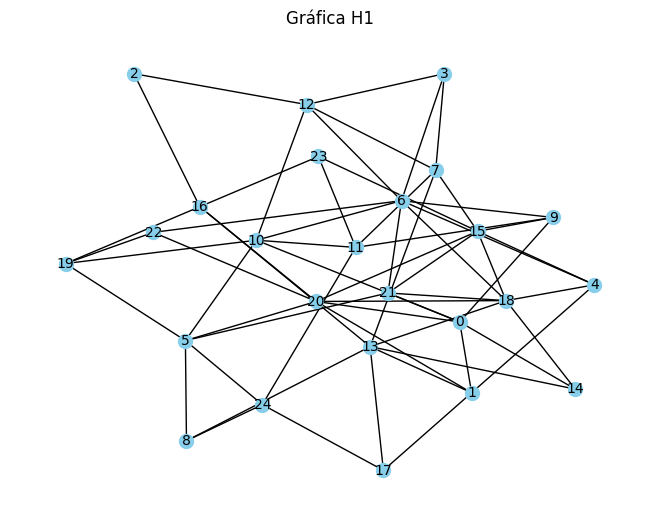

In [ ]:
nx.draw(h1, with_labels=True, node_color='skyblue', node_size=100, font_size=10)
plt.title('Gráfica H1')
plt.show()

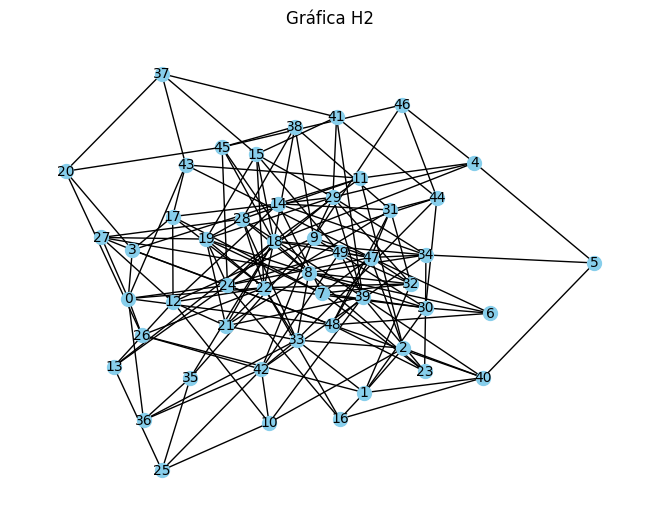

In [ ]:
nx.draw(h2, with_labels=True, node_color='skyblue', node_size=100, font_size=10)
plt.title('Gráfica H2')
plt.show()

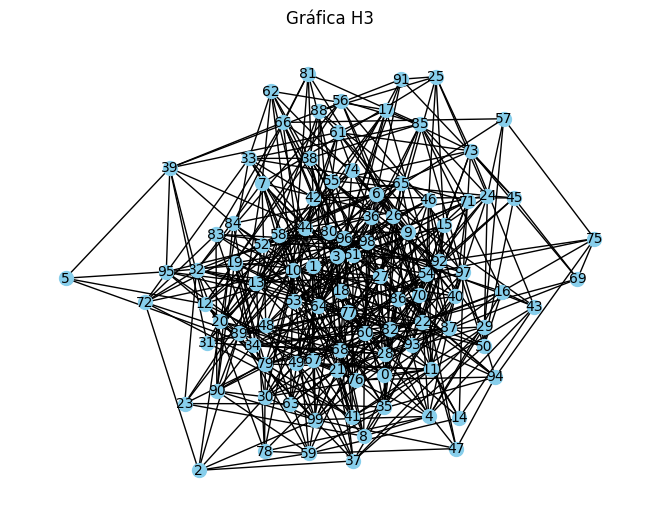

In [ ]:
nx.draw(h3, with_labels=True, node_color='skyblue', node_size=100, font_size=10)
plt.title('Gráfica H3')
plt.show()

### Construcción de soluciones iniciales

In [ ]:
random.seed(2)
h1_s0_greedy = greedy(h1)
h1_s0_r = genera_solucion_aleatoria(h1)

In [ ]:
funcion_f(h1_s0_greedy,h1)

24

In [ ]:
funcion_f(h1_s0_r,h1)

20

In [ ]:
random.seed(2)
h2_s0_greedy = greedy(h2)
h2_s0_r = genera_solucion_aleatoria(h2)

In [ ]:
funcion_f(h2_s0_greedy, h2)

48

In [ ]:
funcion_f(h2_s0_r, h2)

44

In [ ]:
random.seed(1)
h3_s0_greedy = greedy(h3)
h3_s0_r = genera_solucion_aleatoria(h3)

In [ ]:
funcion_f(h3_s0_greedy, h3)

96

In [ ]:
funcion_f(h3_s0_r, h3)

87

### Instancia 4

25 vértices

#### Solución Greedy

##### VecindadC (Default)

In [ ]:
random.seed(0)
h1_s_greedy_bl = busqueda_local(h1, h1_s0_greedy)
h1_s_greedy_grasp_c = grasp_c(h1, 2)
h1_s_greedy_grasp_v = grasp_v(h1, 0.5)
h1_s_greedy_grasp_pg = grasp_pg(h1)
h1_s_greedy_rsim = rsim(h1, h1_s0_greedy, beta = 0.5, prinT=False, graph=False)
h1_s_greedy_tabu = tabu(h1, h1_s0_greedy)
h1_s_greedy_gen = geneticos(h1, 25, h1_s0_greedy, i = 50)

h1_s_greedy_bl[1:], h1_s_greedy_grasp_c[1:], h1_s_greedy_grasp_v[1:], h1_s_greedy_grasp_pg[1:], h1_s_greedy_rsim[1:], h1_s_greedy_tabu[1:], h1_s_greedy_gen[1:]

((17, 0.072214),
 (17, 0.07172999999999999),
 (17, 0.069521),
 (17, 0.066689),
 (20, 0.026538),
 (17, 0.043706),
 (22, 0.036143))

VecindadRK, 16 vecinos

In [ ]:
random.seed(3)
h1_s_greedy_bl_rk = busqueda_local(h1, h1_s0_greedy, N=vecindadRK, m=16)
h1_s_greedy_grasp_c_rk = grasp_c(h1, 2, N=vecindadRK, m=16)
h1_s_greedy_grasp_v_rk = grasp_v(h1, 0.4, N=vecindadRK, m=16)
h1_s_greedy_grasp_pg_rk = grasp_pg(h1, N=vecindadRK, m=16)
h1_s_greedy_rsim_rk = rsim(h1, h1_s0_greedy, N=vecindadRK, m=16, prinT=False, graph=False)
h1_s_greedy_tabu_rk = tabu(h1, h1_s0_greedy, N=vecindadRK, m=16)

h1_s_greedy_bl_rk[1:], h1_s_greedy_grasp_c_rk[1:], h1_s_greedy_grasp_v_rk[1:], h1_s_greedy_grasp_pg_rk[1:], h1_s_greedy_rsim_rk[1:], h1_s_greedy_tabu_rk[1:]

((18, 0.046507),
 (17, 0.029014),
 (17, 0.02812),
 (17, 0.028598000000000002),
 (19, 0.019519),
 (17, 0.027826))

#### Solucion Aleatoria

##### VecindadC

In [ ]:
random.seed(2)
h1_s_rand_bl = busqueda_local(h1, h1_s0_r)
h1_s_rand_rsim = rsim(h1, h1_s0_r, beta = 1, prinT=False, graph=False)
h1_s_rand_tabu = tabu(h1, h1_s0_r)
h1_s_rand_gen = geneticos(h1, 20, h1_s0_r, i = 70)

h1_s_rand_bl[1:], h1_s_rand_rsim[1:], h1_s_rand_tabu[1:], h1_s_rand_gen[1:]

((17, 0.049537), (18, 0.012573), (17, 0.038042), (18, 0.039445))

##### VecindadRK, 16 vecinos

In [ ]:
random.seed(2)
h1_s_rand_bl_rk = busqueda_local(h1, h1_s0_r, N=vecindadRK, m=16)
h1_s_rand_rsim_rk = rsim(h1, h1_s0_r, N=vecindadRK, m=16, prinT=False, graph=False)
h1_s_rand_tabu_rk = tabu(h1, h1_s0_r, N=vecindadRK, m=16)

h1_s_rand_bl_rk[1:], h1_s_rand_rsim_rk[1:], h1_s_rand_tabu_rk[1:]

((17, 0.02963), (20, 0.014906), (17, 0.029164))

In [ ]:
h1_s_greedy_grasp_c[:-1]

([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
 17)

In [ ]:
graph_inducida(h1_s_greedy_grasp_c[0])

[1, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24]

### Instancia 5

50 vértices

#### Solución Greedy

##### VecindadC

In [ ]:
random.seed(2)
h2_s_greedy_bl = busqueda_local(h2, h2_s0_greedy)
h2_s_greedy_grasp_c = grasp_c(h2, 2)
h2_s_greedy_grasp_v = grasp_v(h2, 0.5)
h2_s_greedy_grasp_pg = grasp_pg(h2)
h2_s_greedy_rsim = rsim(h2, h2_s0_greedy, prinT=False, graph=False)
h2_s_greedy_tabu = tabu(h2, h2_s0_greedy)
h2_s_greedy_gen = geneticos(h2, 20, h2_s0_greedy, i = 50)

h2_s_greedy_bl[1:], h2_s_greedy_grasp_c[1:], h2_s_greedy_grasp_v[1:], h2_s_greedy_grasp_pg[1:], h2_s_greedy_rsim[1:], h2_s_greedy_tabu[1:], h2_s_greedy_gen[1:]

((36, 0.163182),
 (36, 0.163691),
 (36, 0.153151),
 (36, 0.171197),
 (40, 0.046705),
 (36, 0.151885),
 (46, 0.065345))

##### VecindadRK, 32 vecinos

In [ ]:
random.seed(2)
h2_s_greedy_bl_rk = busqueda_local(h2, h2_s0_greedy, N=vecindadRK, m=32)
h2_s_greedy_grasp_c_rk = grasp_c(h2, 2, N=vecindadRK, m=32)
h2_s_greedy_grasp_v_rk = grasp_v(h2, 0.5, N=vecindadRK, m=32)
h2_s_greedy_grasp_pg_rk = grasp_pg(h2, N=vecindadRK, m=32)
h2_s_greedy_rsim_rk = rsim(h2, h2_s0_greedy, N=vecindadRK, m=32, prinT=False, graph=False)
h2_s_greedy_tabu_rk = tabu(h2, h2_s0_greedy, N=vecindadRK, m=32)

h2_s_greedy_bl_rk[1:], h2_s_greedy_grasp_c_rk[1:], h2_s_greedy_grasp_v_rk[1:], h2_s_greedy_grasp_pg_rk[1:], h2_s_greedy_rsim_rk[1:], h2_s_greedy_tabu_rk[1:]

((35, 0.115392),
 (37, 0.13436499999999998),
 (37, 0.13662700000000003),
 (38, 0.11575099999999999),
 (40, 0.047655),
 (36, 0.117674))

#### Solucion Aleatoria

##### VecindadC

In [ ]:
random.seed(1)
h2_s_rand_bl = busqueda_local(h2, h2_s0_r)
h2_s_rand_rsim = rsim(h2, h2_s0_r, prinT=False, graph=False)
h2_s_rand_tabu = tabu(h2, h2_s0_r)
h2_s_rand_gen = geneticos(h2, 20, h2_s0_r, i = 50)

h2_s_rand_bl[1:], h2_s_rand_rsim[1:], h2_s_rand_tabu[1:], h2_s_rand_gen[1:]

((36, 0.476361), (39, 0.068109), (36, 0.555608), (43, 0.127934))

##### VecindadRK, 32 vecinos

In [ ]:
random.seed(2)
h2_s_rand_bl_rk = busqueda_local(h2, h2_s0_r, N=vecindadRK, m=32)
h2_s_rand_rsim_rk = rsim(h2, h2_s0_r, N=vecindadRK, m=32, prinT=False, graph=False)
h2_s_rand_tabu_rk = tabu(h2, h2_s0_r, N=vecindadRK, m=32)

h2_s_rand_bl_rk[1:], h2_s_rand_rsim_rk[1:], h2_s_rand_tabu_rk[1:]

((37, 0.114295), (39, 0.048873), (37, 0.116063))

In [ ]:
print(h2_s_greedy_bl_rk[:-1])

([0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0], 35)


In [ ]:
print(graph_inducida(h2_s_greedy_bl_rk[0]))

[2, 3, 4, 7, 8, 12, 14, 15, 16, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48]


### Instancia 6

100 vértices

#### Solución Greedy

##### VecindadC (Default)

In [ ]:
random.seed(2)
h3_s_greedy_bl = busqueda_local(h3, h3_s0_greedy)
h3_s_greedy_grasp_c = grasp_c(h3, 2)
h3_s_greedy_grasp_v = grasp_v(h3, 0.5)
h3_s_greedy_grasp_pg = grasp_pg(h3)
h3_s_greedy_rsim = rsim(h3, h3_s0_greedy, prinT=False, graph=False)
h3_s_greedy_tabu = tabu(h3, h3_s0_greedy)
h3_s_greedy_gen = geneticos(h3, 20, h3_s0_greedy, i = 50)

h3_s_greedy_bl[1:], h3_s_greedy_grasp_c[1:], h3_s_greedy_grasp_v[1:], h3_s_greedy_grasp_pg[1:], h3_s_greedy_rsim[1:], h3_s_greedy_tabu[1:], h3_s_greedy_gen[1:]


((80, 0.684012),
 (80, 0.702574),
 (80, 0.6937920000000001),
 (80, 0.704323),
 (86, 0.107097),
 (80, 0.67286),
 (94, 0.176602))

##### VecindadRK, 20 vecinos

In [ ]:
random.seed(2)
h3_s_greedy_bl_rk = busqueda_local(h3, h3_s0_greedy, N=vecindadRK, m=64)
h3_s_greedy_grasp_c_rk = grasp_c(h3, 2, N=vecindadRK, m=64)
h3_s_greedy_grasp_v_rk = grasp_v(h3, 0.5, N=vecindadRK, m=64)
h3_s_greedy_grasp_pg_rk = grasp_pg(h3, N=vecindadRK, m=64)
h3_s_greedy_rsim_rk = rsim(h3, h3_s0_greedy, N=vecindadRK, m=64, prinT=False, graph=False)
h3_s_greedy_tabu_rk = tabu(h3, h3_s0_greedy, N=vecindadRK, m=64)

h3_s_greedy_bl_rk[1:], h3_s_greedy_grasp_c_rk[1:], h3_s_greedy_grasp_v_rk[1:], h3_s_greedy_grasp_pg_rk[1:], h3_s_greedy_rsim_rk[1:], h3_s_greedy_tabu_rk[1:]


((81, 0.513831),
 (76, 0.619764),
 (78, 0.676751),
 (80, 0.5913109999999999),
 (86, 0.122659),
 (77, 0.48083))

#### Solucion Aleatoria

##### VecindadC

In [ ]:
random.seed(3)
h3_s_rand_bl = busqueda_local(h3, h3_s0_r)
h3_s_rand_rsim = rsim(h3, h3_s0_r, prinT=False, graph=False)
h3_s_rand_tabu = tabu(h3, h3_s0_r)
h3_s_rand_gen = geneticos(h3, 40, h3_s0_r)

h3_s_rand_bl[1:], h3_s_rand_rsim[1:], h3_s_rand_tabu[1:], h3_s_rand_gen[1:]

((78, 1.169449), (87, 0.217131), (78, 1.447892), (86, 0.129833))

##### VecindadRK, 20 vecinos

In [ ]:
random.seed(2)
h3_s0_rand_bl_rk = busqueda_local(h3, h3_s0_r, N=vecindadRK, m=64)
h3_s0_rand_rsim_rk = rsim(h3, h3_s0_r, N=vecindadRK, m=64, prinT=False, graph=False)
h3_s0_rand_tabu_rk = tabu(h3, h3_s0_r, N=vecindadRK, m=64)

h3_s0_rand_bl_rk[1:], h3_s0_rand_rsim_rk[1:], h3_s0_rand_tabu_rk[1:]


((78, 0.681201), (86, 0.12764), (77, 0.562679))

In [ ]:
print(h3_s_greedy_grasp_c_rk[:-1])

([0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1], 76)


In [ ]:
print(graph_inducida(h3_s_greedy_grasp_c_rk[0]))

[1, 3, 4, 5, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 54, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 71, 72, 73, 75, 76, 77, 78, 79, 80, 82, 84, 85, 86, 88, 89, 90, 91, 92, 95, 97, 98, 99]


## Tamaño "grande"

In [ ]:
n1_q, n2_q, n3_q = 200, 350, 500

random.seed(2)
q1 = genera_grafica_aleatoria(n1_q, 0.01)
q2 = genera_grafica_aleatoria(n2_q, 0.005)
q3 = genera_grafica_aleatoria(n3_q, 0.001)

### Construcción de soluciones iniciales

In [ ]:
random.seed(2)
q1_s0_greedy = greedy(q1)
q1_s0_r = genera_solucion_aleatoria(q1)

In [ ]:
funcion_f(q1_s0_greedy, q1), funcion_f(q1_s0_r, q1)

(175, 155)

In [ ]:
random.seed(2)
q2_s0_greedy = greedy(q2)
q2_s0_r = genera_solucion_aleatoria(q2, p=0.8)

In [ ]:
funcion_f(q2_s0_greedy, q2), funcion_f(q2_s0_r, q2)

(334, 278)

In [ ]:
random.seed(2)
q3_s0_greedy = greedy(q3)
q3_s0_r = genera_solucion_aleatoria(q3, p=0.8)

In [ ]:
funcion_f(q3_s0_greedy, q3), funcion_f(q3_s0_r, q3)

(491, 397)

### Instancia 7

200 vértices

#### Solución Greedy

##### VecindadC (Default)

In [ ]:
random.seed(2)
q1_s_greedy_bl = busqueda_local(q1, q1_s0_greedy)
q1_s_greedy_grasp_c = grasp_c(q1, 2)
q1_s_greedy_grasp_v = grasp_v(q1, 0.5)
q1_s_greedy_grasp_pg = grasp_pg(q1)
q1_s_greedy_rsim = rsim(q1, q1_s0_greedy, prinT=False, graph=False)
q1_s_greedy_tabu = tabu(q1, q1_s0_greedy)
q1_s_greedy_gen = geneticos(q1, 50, q1_s0_greedy, i = 100)

q1_s_greedy_bl[1:], q1_s_greedy_grasp_c[1:], q1_s_greedy_grasp_v[1:], q1_s_greedy_grasp_pg[1:], q1_s_greedy_rsim[1:], q1_s_greedy_tabu[1:], q1_s_greedy_gen[1:]

((93, 3.068298),
 (100, 2.3332450000000002),
 (100, 2.293215),
 (100, 2.30844),
 (134, 0.327595),
 (93, 2.399737),
 (173, 0.617382))

##### VecindadRK, 128 vecinos

In [ ]:
random.seed(2)
q1_s_greedy_bl_rk = busqueda_local(q1, q1_s0_greedy, N=vecindadRK, m=128)
q1_s_greedy_grasp_c_rk = grasp_c(q1, 2, N=vecindadRK, m=128)
q1_s_greedy_grasp_v_rk = grasp_v(q1, 0.5, N=vecindadRK, m=128)
q1_s_greedy_grasp_pg_rk = grasp_pg(q1, N=vecindadRK, m=128)
q1_s_greedy_rsim_rk = rsim(q1, q1_s0_greedy, N=vecindadRK, m=128, prinT=False, graph=False)
q1_s_greedy_tabu_rk = tabu(q1, q1_s0_greedy, N=vecindadRK, m=128)

q1_s_greedy_bl_rk[1:], q1_s_greedy_grasp_c_rk[1:], q1_s_greedy_grasp_v_rk[1:], q1_s_greedy_grasp_pg_rk[1:], q1_s_greedy_rsim_rk[1:], q1_s_greedy_tabu_rk[1:]

((89, 1.168197),
 (100, 1.243142),
 (100, 1.225159),
 (100, 2.190626),
 (133, 0.203731),
 (89, 1.488443))

#### Solucion Aleatoria

##### VecindadC

In [ ]:
random.seed(2)
q1_s_rand_bl = busqueda_local(q1, q1_s0_r)
q1_s_rand_rsim = rsim(q1, q1_s0_r, prinT=False, graph=False)
q1_s_rand_tabu = tabu(q1, q1_s0_r)
q1_s_rand_gen = geneticos(q1, 50, q1_s0_r, i = 100)

q1_s_rand_bl[1:], q1_s_rand_rsim[1:], q1_s_rand_tabu[1:], q1_s_rand_gen[1:]

((87, 2.467907), (130, 0.105749), (87, 2.100685), (153, 1.076424))

##### VecindadRK, 128 vecinos

In [ ]:
random.seed(2)
q1_s_rand_bl_rk = busqueda_local(q1, q1_s0_r, N=vecindadRK, m=128)
q1_s_rand_rsim_rk = rsim(q1, q1_s0_r, N=vecindadRK, m=128, prinT=False, graph=False)
q1_s_rand_tabu_rk = tabu(q1, q1_s0_r, N=vecindadRK, m=128)

q1_s_rand_bl_rk[1:], q1_s_rand_rsim_rk[1:], q1_s_rand_tabu_rk[1:]

((87, 2.477896), (144, 0.107442), (87, 1.108987))

### Instancia 8

350 vértices

#### Solución Greedy

##### VecindadC (Default)

In [ ]:
random.seed(2)
q2_s_greedy_bl = busqueda_local(q2, q2_s0_greedy)
q2_s_greedy_grasp_c = grasp_c(q2, 2)
q2_s_greedy_grasp_v = grasp_v(q2, 0.5)
q2_s_greedy_grasp_pg = grasp_pg(q2)
q2_s_greedy_rsim = rsim(q2, q2_s0_greedy, prinT=False, graph=False)
q2_s_greedy_tabu = tabu(q2, q2_s0_greedy)
q2_s_greedy_gen = geneticos(q2, 50, q2_s0_greedy, i = 100)

q2_s_greedy_bl[1:], q2_s_greedy_grasp_c[1:], q2_s_greedy_grasp_v[1:], q2_s_greedy_grasp_pg[1:], q2_s_greedy_rsim[1:], q2_s_greedy_tabu[1:], q2_s_greedy_gen[1:]

((234, 6.212787),
 (250, 6.95448),
 (250, 8.007793),
 (250, 5.333915),
 (246, 0.21677),
 (234, 6.904577),
 (332, 1.11471))

##### VecindadRK, 224 vecinos

In [ ]:
random.seed(2)
q2_s_greedy_bl_rk = busqueda_local(q2, q2_s0_greedy, N=vecindadRK, m=224)
q2_s_greedy_grasp_c_rk = grasp_c(q2, 2, N=vecindadRK, m=224)
q2_s_greedy_grasp_v_rk = grasp_v(q2, 0.5, N=vecindadRK, m=224)
q2_s_greedy_grasp_pg_rk = grasp_pg(q2, N=vecindadRK, m=224)
q2_s_greedy_rsim_rk = rsim(q2, q2_s0_greedy, N=vecindadRK, m=224, prinT=False, graph=False)
q2_s_greedy_tabu_rk = tabu(q2, q2_s0_greedy, N=vecindadRK, m=224)

q2_s_greedy_bl_rk[1:], q2_s_greedy_grasp_c_rk[1:], q2_s_greedy_grasp_v_rk[1:], q2_s_greedy_grasp_pg_rk[1:], q2_s_greedy_rsim_rk[1:], q2_s_greedy_tabu_rk[1:]


((234, 4.088268),
 (250, 4.273083000000001),
 (250, 5.705126),
 (250, 4.448897),
 (244, 0.234291),
 (234, 4.01963))

#### Solucion Aleatoria

##### VecindadC

In [ ]:
random.seed(2)
q2_s_rand_bl = busqueda_local(q2, q2_s0_r)
q2_s_rand_rsim = rsim(q2, q2_s0_r, prinT=False, graph=False)
q2_s_rand_tabu = tabu(q2, q2_s0_r)
q2_s_rand_gen = geneticos(q2, 50, q2_s0_r, i = 100)

q2_s_rand_bl[1:], q2_s_rand_rsim[1:], q2_s_rand_tabu[1:], q2_s_rand_gen[1:]

((178, 7.634702), (239, 0.231093), (178, 4.959789), (276, 1.493229))

##### VecindadRK, 224 vecinos

In [ ]:
random.seed(2)
q2_s_rand_bl_rk = busqueda_local(q2, q2_s0_r, N=vecindadRK, m=224)
q2_s_rand_rsim_rk = rsim(q2, q2_s0_r, N=vecindadRK, m=224, prinT=False, graph=False)
q2_s_rand_tabu_rk = tabu(q2, q2_s0_r, N=vecindadRK, m=224)

q2_s_rand_bl_rk[1:], q2_s_rand_rsim_rk[1:], q2_s_rand_tabu_rk[1:]

((178, 4.107247), (240, 0.224266), (178, 3.231825))

### Instancia 9

500 vértices

#### Solución Greedy

##### VecindadC (Default)

In [ ]:
random.seed(2)
q3_s_greedy_bl = busqueda_local(q3, q3_s0_greedy)
q3_s_greedy_grasp_c = grasp_c(q3, 2)
q3_s_greedy_grasp_v = grasp_v(q3, 0.5)
q3_s_greedy_grasp_pg = grasp_pg(q3)
q3_s_greedy_rsim = rsim(q3, q3_s0_greedy, prinT=False, graph=False)
q3_s_greedy_tabu = tabu(q3, q3_s0_greedy)
q3_s_greedy_gen = geneticos(q3, 50, q3_s0_greedy, i = 100)

q3_s_greedy_bl[1:], q3_s_greedy_grasp_c[1:], q3_s_greedy_grasp_v[1:], q3_s_greedy_grasp_pg[1:], q3_s_greedy_rsim[1:], q3_s_greedy_tabu[1:], q3_s_greedy_gen[1:]

((391, 13.116923),
 (400, 11.615558),
 (400, 12.456328000000001),
 (400, 11.123892),
 (372, 0.346011),
 (391, 9.383934),
 (489, 0.910144))

##### VecindadRK, 320 vecinos

In [ ]:
random.seed(2)
q3_s_greedy_bl_rk = busqueda_local(q3, q3_s0_greedy, N=vecindadRK, m=320)
q3_s_greedy_grasp_c_rk = grasp_c(q3, 2, N=vecindadRK, m=320)
q3_s_greedy_grasp_v_rk = grasp_v(q3, 0.5, N=vecindadRK, m=320)
q3_s_greedy_grasp_pg_rk = grasp_pg(q3, N=vecindadRK, m=320)
q3_s_greedy_rsim_rk = rsim(q3, q3_s0_greedy, N=vecindadRK, m=320, prinT=False, graph=False)
q3_s_greedy_tabu_rk = tabu(q3, q3_s0_greedy, N=vecindadRK, m=320)

q3_s_greedy_bl_rk[1:], q3_s_greedy_grasp_c_rk[1:], q3_s_greedy_grasp_v_rk[1:], q3_s_greedy_grasp_pg_rk[1:], q3_s_greedy_rsim_rk[1:], q3_s_greedy_tabu_rk[1:]

((391, 5.219426),
 (400, 6.689721),
 (400, 5.317850999999999),
 (400, 6.738844),
 (376, 0.331647),
 (391, 5.20949))

#### Solucion Aleatoria

##### VecindadC

In [ ]:
random.seed(2)
q3_s_rand_bl = busqueda_local(q3, q3_s0_r)
q3_s_rand_rsim = rsim(q3, q3_s0_r, prinT=False, graph=False)
q3_s_rand_tabu = tabu(q3, q3_s0_r)
q3_s_rand_gen = geneticos(q3, 50, q3_s0_r, i = 100)

q3_s_rand_bl[1:], q3_s_rand_rsim[1:], q3_s_rand_tabu[1:], q3_s_rand_gen[1:]

((297, 9.096437), (322, 0.315368), (297, 8.678813), (395, 1.710814))

##### VecindadRK, 320 vecinos

In [ ]:
random.seed(2)
q3_s_rand_bl_rk = busqueda_local(q3, q3_s0_r, N=vecindadRK, m=320)
q3_s_rand_rsim_rk = rsim(q3, q3_s0_r, N=vecindadRK, m=320, prinT=False, graph=False)
q3_s_rand_tabu_rk = tabu(q3, q3_s0_r, N=vecindadRK, m=320)

q3_s_rand_bl_rk[1:], q3_s_rand_rsim_rk[1:], q3_s_rand_tabu_rk[1:]

((297, 5.079266), (328, 0.29862), (297, 7.810231))